In [16]:
import pyspark
from pyspark.sql import SparkSession


In [17]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName('nyc_taxi_notebook_04') \
    .getOrCreate()

In [18]:
spark.sparkContext.uiWebUrl

'http://spark-medium.europe-southwest1-a.c.de-zoomcamp-jhigaki-course.internal:4040'

In [19]:
df_yellow_metrics = spark.read\
    .parquet(f'tmp-data/pq/reports/yellow/*')
df_green_metrics = spark.read\
    .parquet(f'tmp-data/pq/reports/green/*')

In [20]:
df_yellow_metrics = df_yellow_metrics\
    .withColumnRenamed('total_amount', 'yellow_total_amount')\
    .withColumnRenamed('passenger_count', 'yellow_passenger_count')\
    .withColumnRenamed('passenger_count', 'yellow_passenger_count')\
    .withColumnRenamed('trip_distance', 'yellow_trip_distance')\
    .withColumnRenamed('trip_count', 'yellow_trip_count')

In [21]:
df_green_metrics = df_green_metrics\
    .withColumnRenamed('total_amount', 'green_total_amount')\
    .withColumnRenamed('passenger_count', 'green_passenger_count')\
    .withColumnRenamed('passenger_count', 'green_passenger_count')\
    .withColumnRenamed('trip_distance', 'green_trip_distance')\
    .withColumnRenamed('trip_count', 'green_trip_count')

In [22]:
df_yellow_metrics.show(10)

+-------------------+------------+-------------------+----------------------+--------------------+-----------------+------------+
|        pickup_hour|PULocationID|yellow_total_amount|yellow_passenger_count|yellow_trip_distance|yellow_trip_count|service_type|
+-------------------+------------+-------------------+----------------------+--------------------+-----------------+------------+
|2019-01-01 00:00:00|           4|             731.72|                  73.0|              136.87|               49|     yelllow|
|2019-01-01 00:00:00|           7|             332.61|                  31.0|               74.12|               25|     yelllow|
|2019-01-01 00:00:00|          10|               28.6|                   2.0|                6.04|                2|     yelllow|
|2019-01-01 00:00:00|          11|               18.6|                   3.0|                3.59|                2|     yelllow|
|2019-01-01 00:00:00|          12|              55.55|                  13.0|  12.44000000

## Join Large tables

In [23]:
df_join = \
    df_green_metrics.join(df_yellow_metrics, \
                          on=['pickup_hour', 'PULocationID'], how='outer')


In [24]:
df_join.show(600)

+-------------------+------------+------------------+---------------------+-------------------+----------------+------------+-------------------+----------------------+--------------------+-----------------+------------+
|        pickup_hour|PULocationID|green_total_amount|green_passenger_count|green_trip_distance|green_trip_count|service_type|yellow_total_amount|yellow_passenger_count|yellow_trip_distance|yellow_trip_count|service_type|
+-------------------+------------+------------------+---------------------+-------------------+----------------+------------+-------------------+----------------------+--------------------+-----------------+------------+
|2019-01-01 00:00:00|          16|50.599999999999994|                  2.0|              15.51|               2|       green|               null|                  null|                null|             null|        null|
|2019-01-01 00:00:00|          18|             75.71|                  8.0|              19.46|               3|    

JOin job
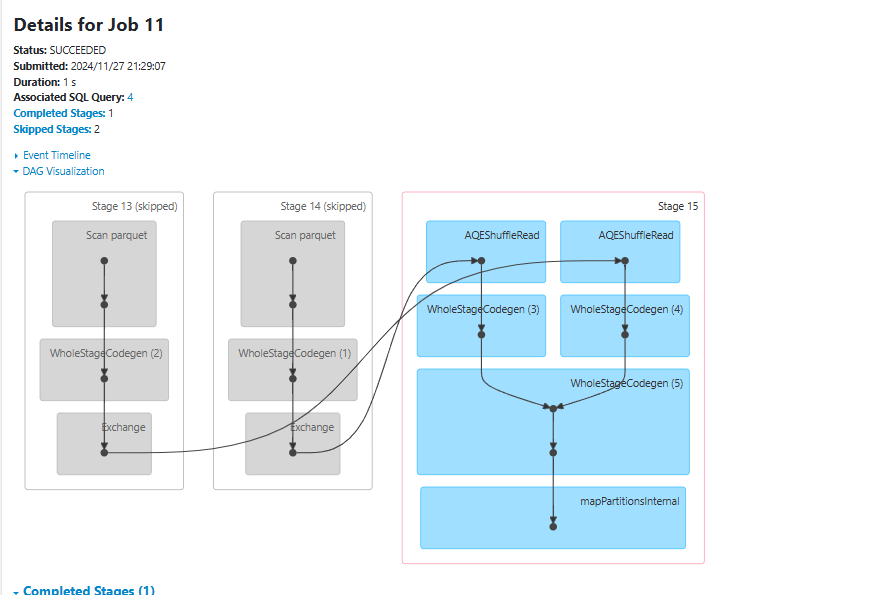

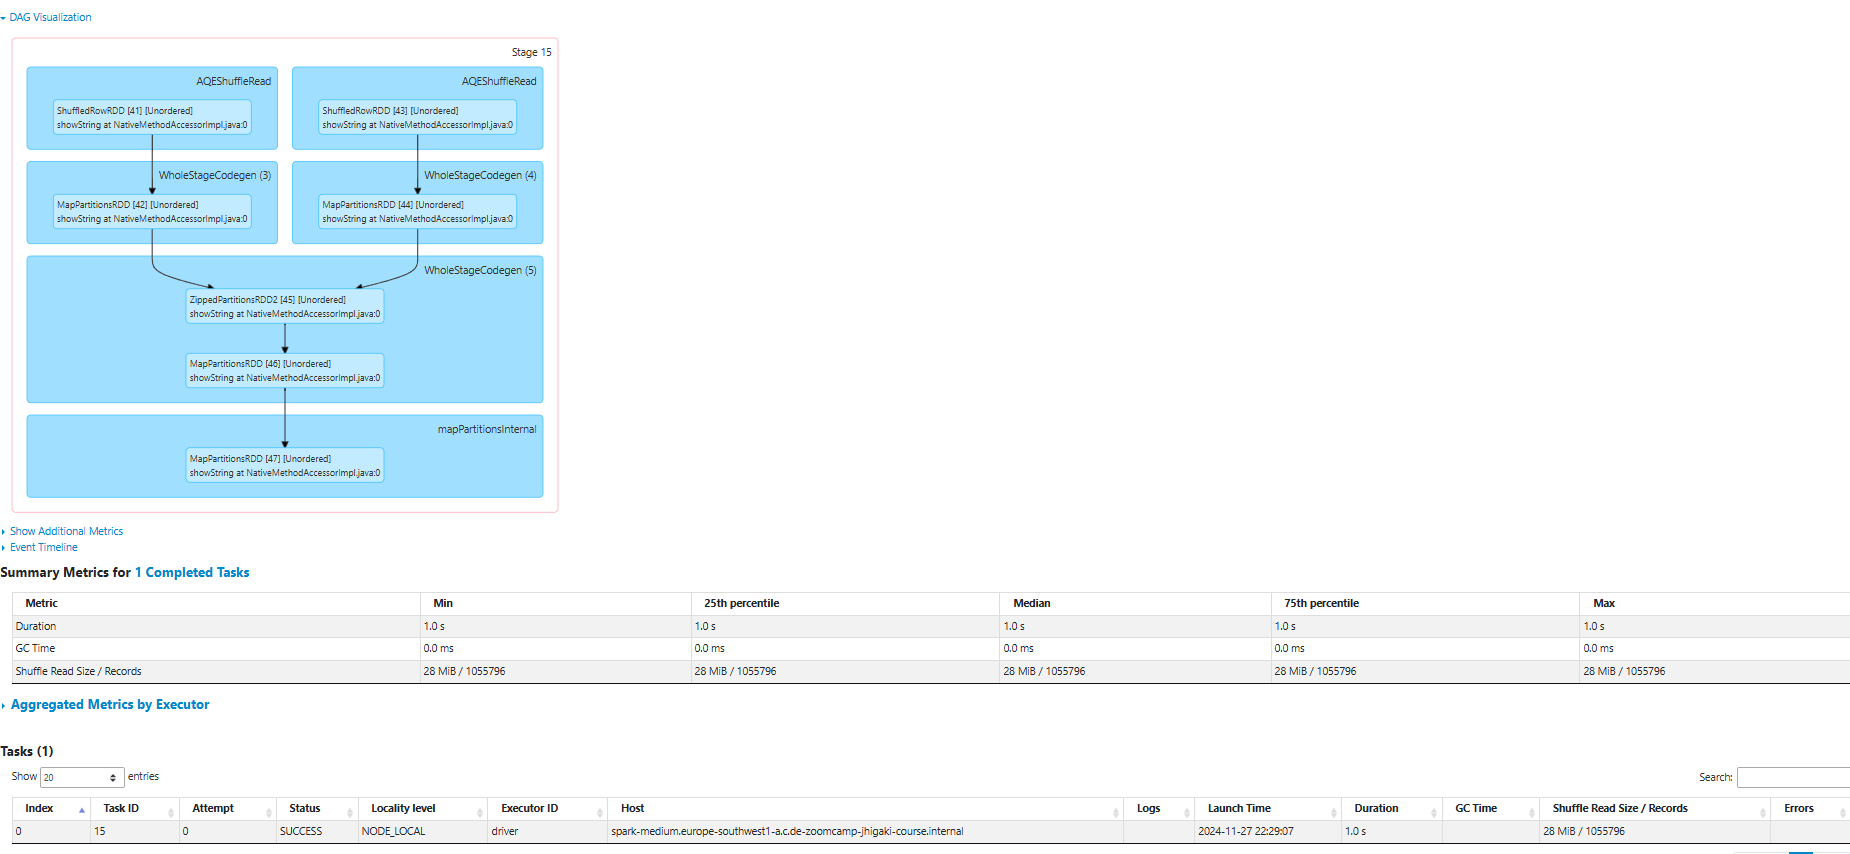

In [25]:
from pyspark.sql import functions as F


In [26]:
df_join_repartition = \
    df_green_metrics.repartition(10).join(df_yellow_metrics.repartition(20), \
                          on=['pickup_hour', 'PULocationID'], how='outer')

In [21]:
df_join_repartition.show(600)

+-------------------+------------+------------------+---------------------+-------------------+----------------+------------+-------------------+----------------------+--------------------+-----------------+------------+
|        pickup_hour|PULocationID|green_total_amount|green_passenger_count|green_trip_distance|green_trip_count|service_type|yellow_total_amount|yellow_passenger_count|yellow_trip_distance|yellow_trip_count|service_type|
+-------------------+------------+------------------+---------------------+-------------------+----------------+------------+-------------------+----------------------+--------------------+-----------------+------------+
|2019-01-01 00:00:00|          16|50.599999999999994|                  2.0|              15.51|               2|       green|               null|                  null|                null|             null|        null|
|2019-01-01 00:00:00|          18|             75.71|                  8.0|              19.46|               3|    

Join job

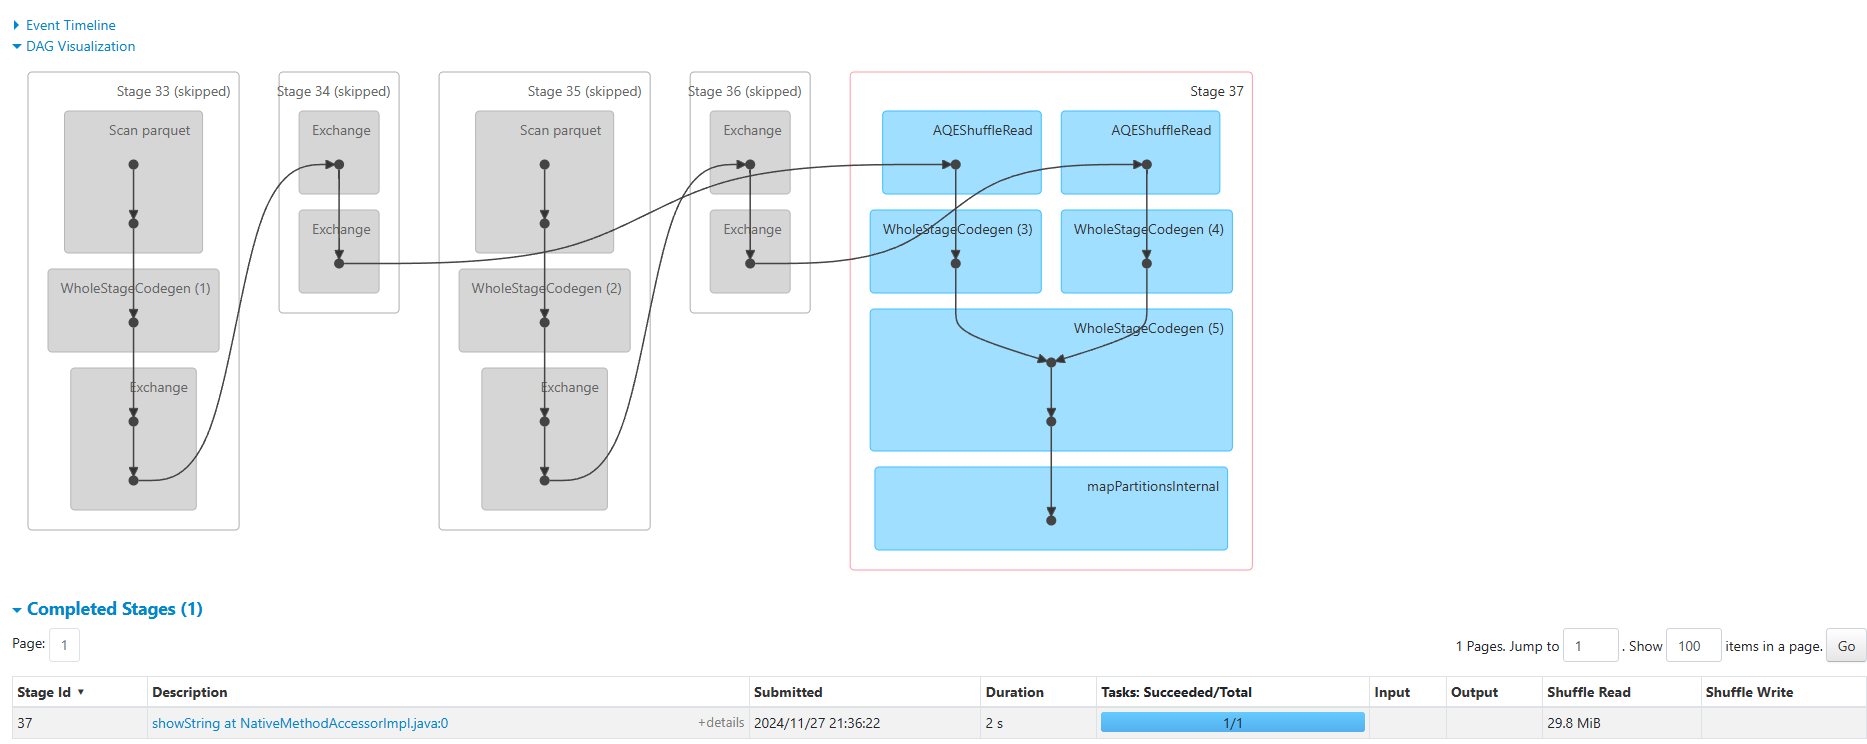

Repartition of yellow into 20 tasks
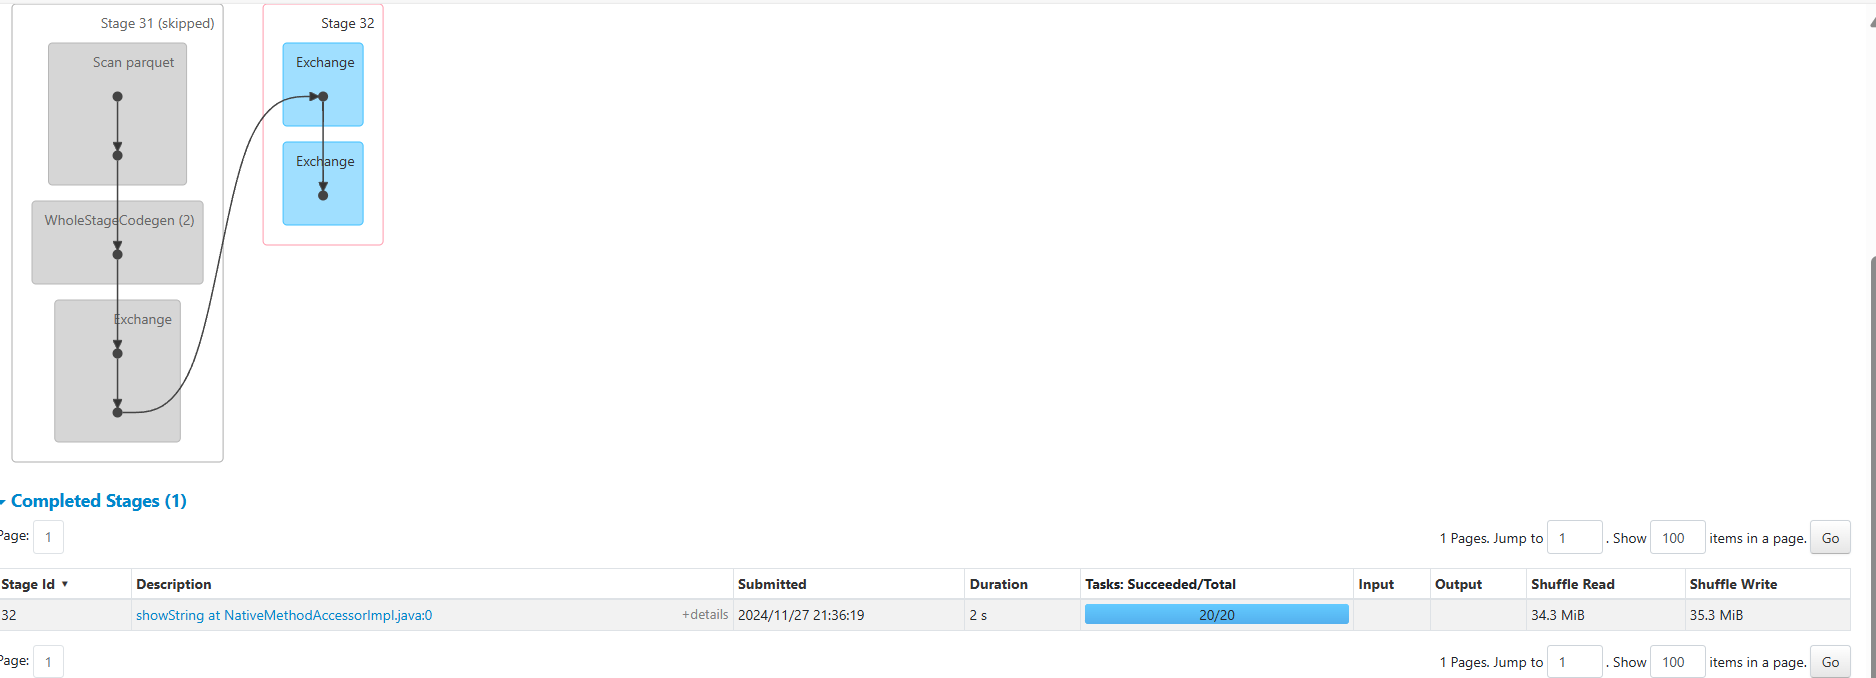

Repartition of green into 10 tasks
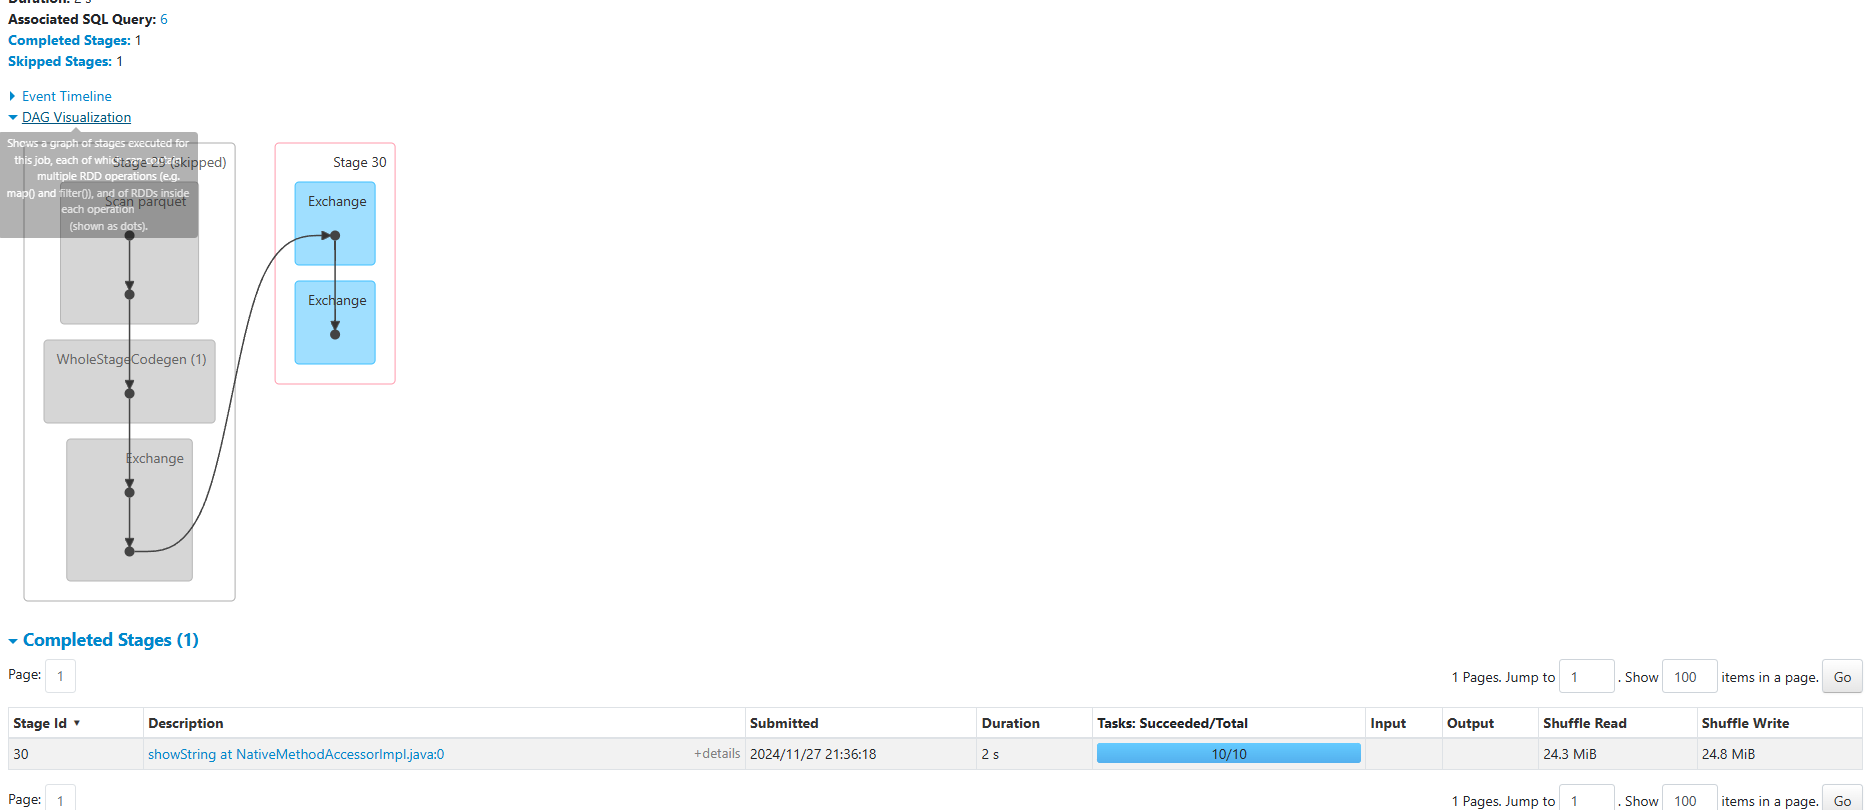



## Joining Small tables

### Load Zone dataset

In [11]:
!wget https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv -O tmp-data/raw/taxi_zone_lookup.csv

--2024-11-28 11:53:15--  https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 3.160.226.85, 3.160.226.161, 3.160.226.228, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|3.160.226.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12331 (12K) [text/csv]
Saving to: ‘tmp-data/raw/taxi_zone_lookup.csv’

tmp-data/raw/taxi_z 100%[===================>]  12.04K  --.-KB/s    in 0s      

2024-11-28 11:53:16 (145 MB/s) - ‘tmp-data/raw/taxi_zone_lookup.csv’ saved [12331/12331]



In [13]:
df_zone = spark.read\
    .option("header", True)\
    .csv("tmp-data/raw/taxi_zone_lookup.csv")



In [14]:
df_zone.show()


+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
|        11|     Brooklyn|          Bath Beach|   Boro Zone|
|        12|    Manhattan|        Battery Park| Yellow Zone|
|        13|    Manhattan|   Battery Park City| Yellow Zone|
|        14|     Brookly

In [15]:
df_zone.write.parquet("tmp-data/pq/zones/")
df_zone = spark.read.parquet("tmp-data/pq/zones/")

Joining to zones

In [64]:
df_join_zone = df_join.join(\
                    df_zone,\
                    df_join["PULocationID"] == df_zone["LocationID"], how="left" 
                    )


In [65]:
df_join_zone_selected = df_join_zone.select("pickup_hour", "Zone", "PULocationID", "yellow_trip_count", "green_trip_count")

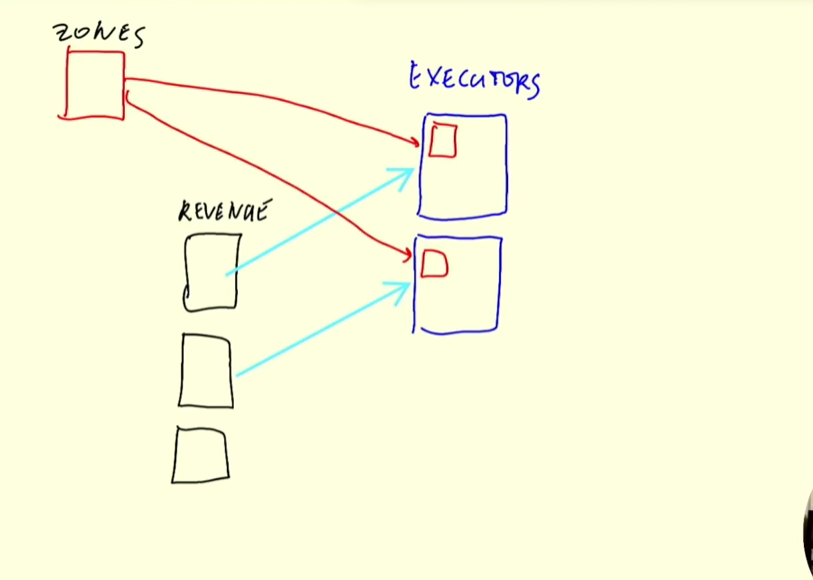


**And produces a broadcast join, cheaper than a merge sort join**



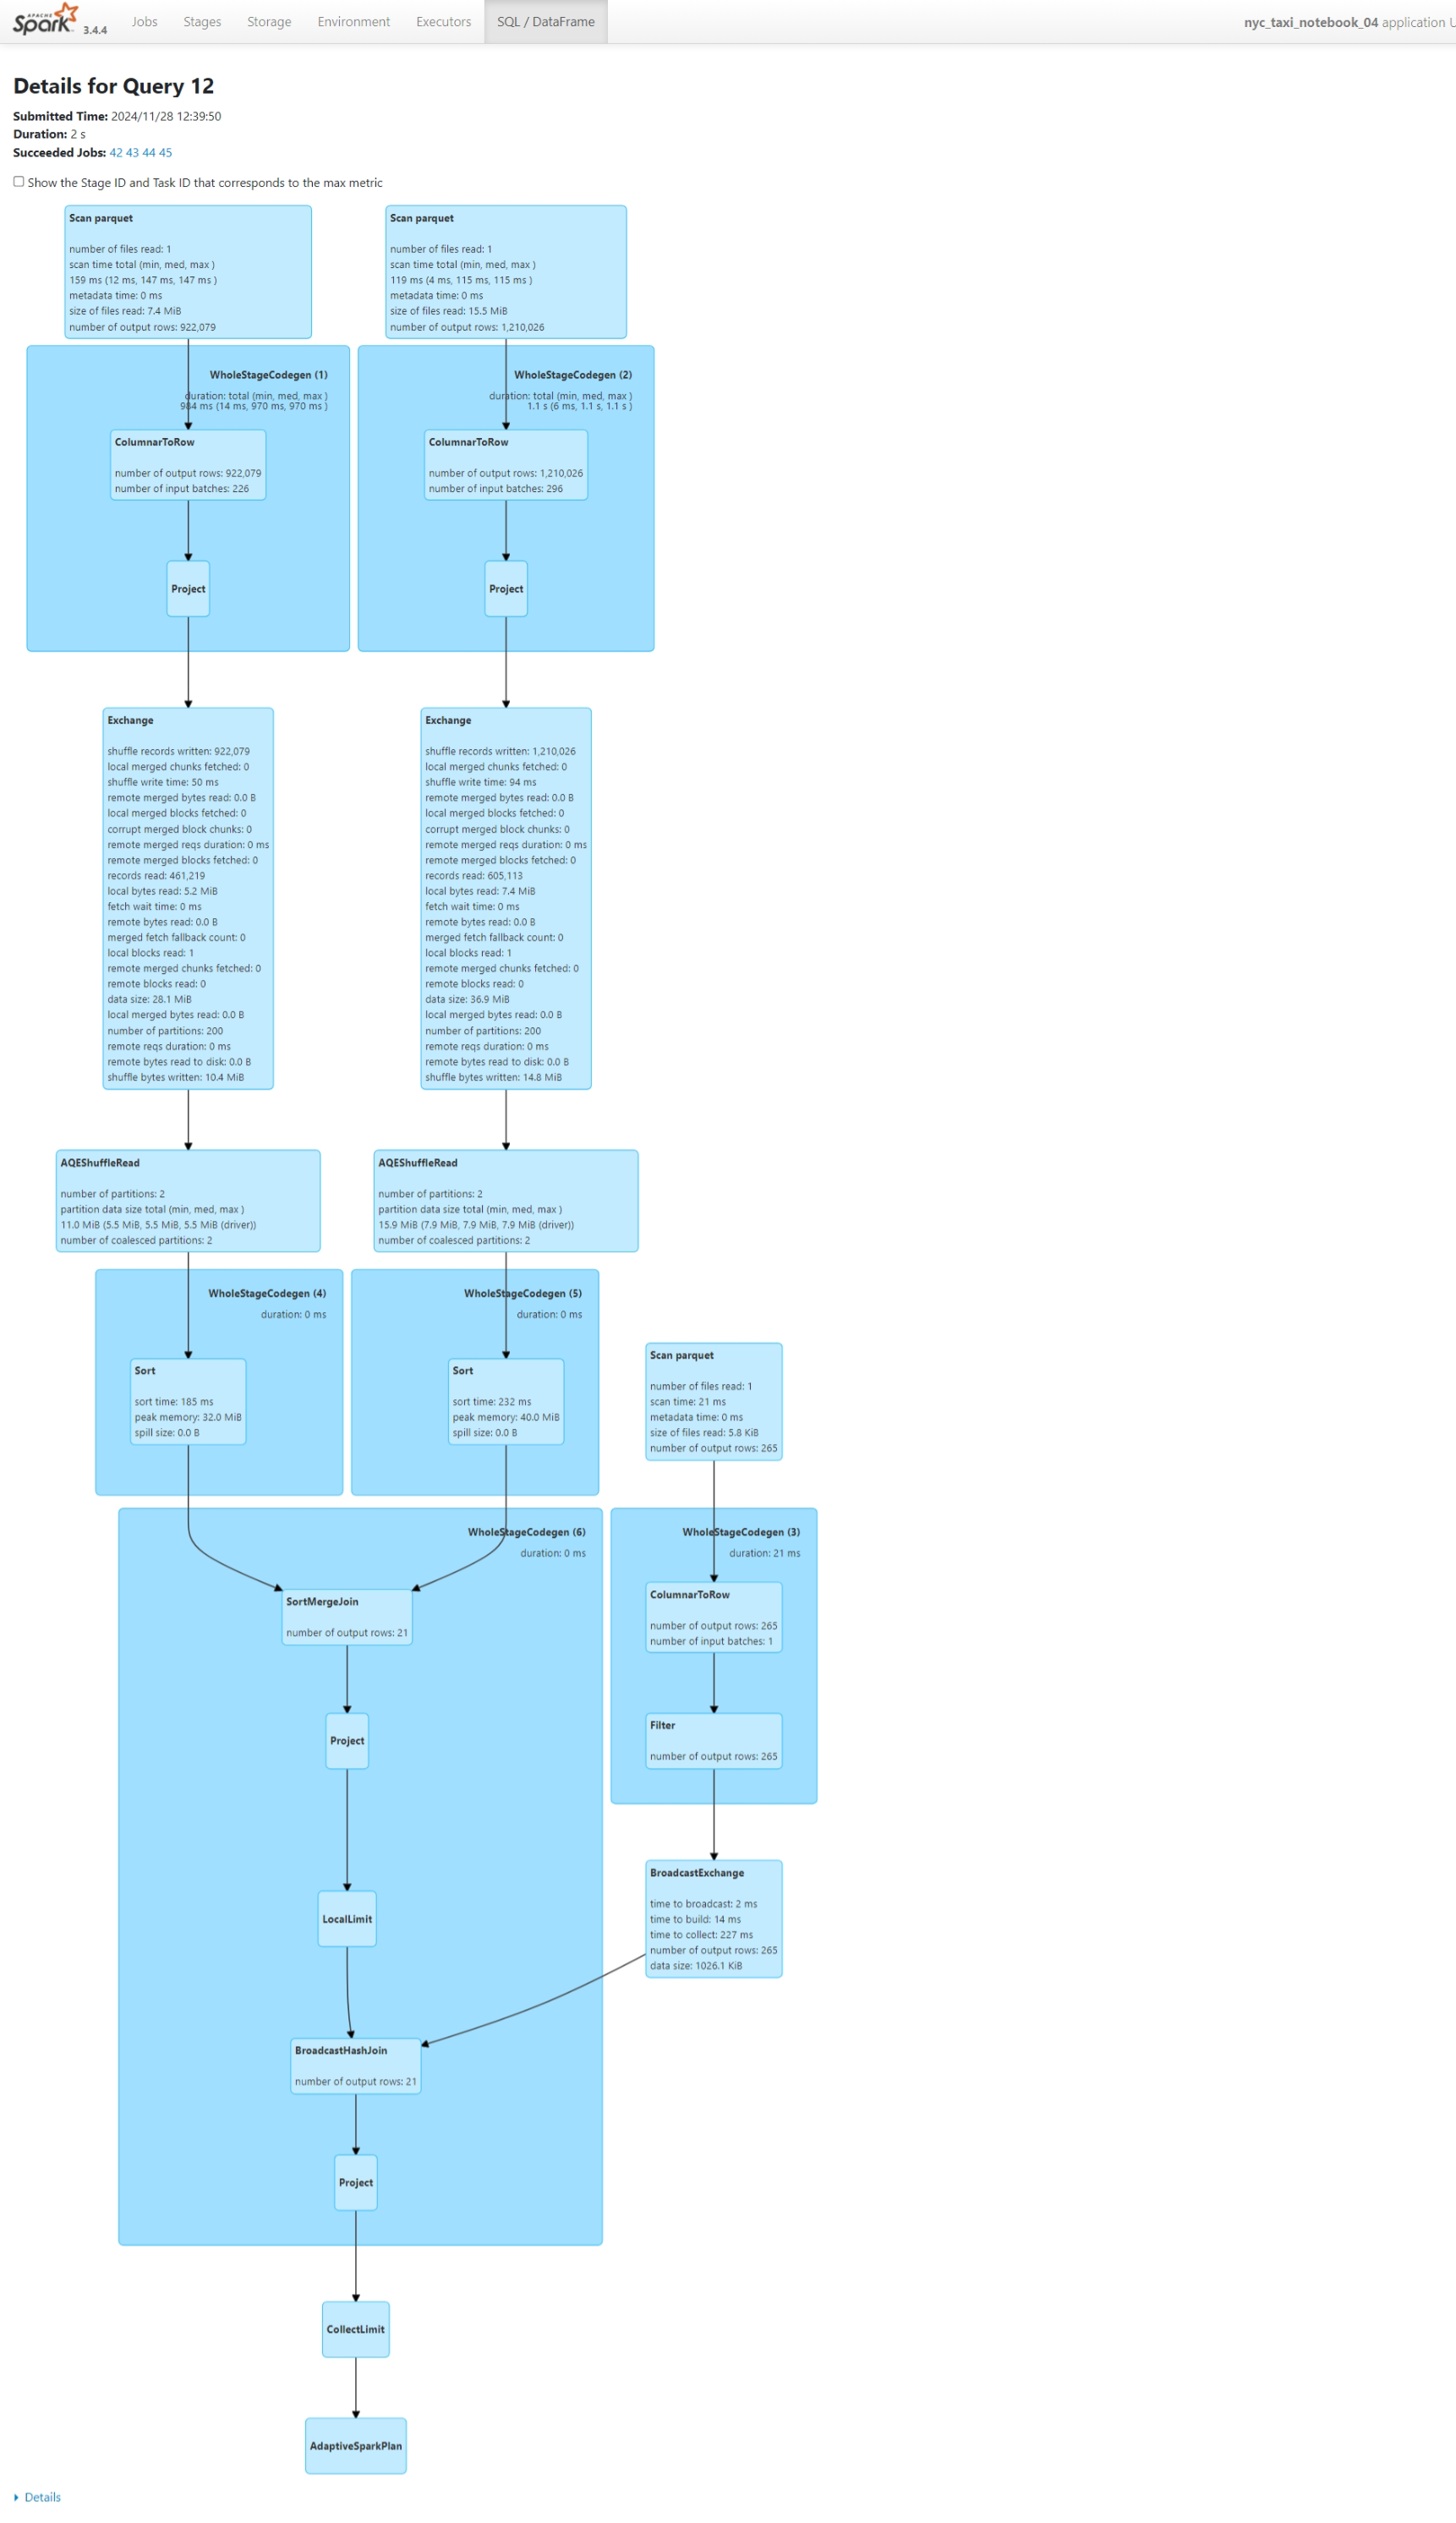

In [ ]:
df_join_zone_selected.show()



+-------------------+--------------------+------------+-----------------+----------------+
|        pickup_hour|                Zone|PULocationID|yellow_trip_count|green_trip_count|
+-------------------+--------------------+------------+-----------------+----------------+
|2019-01-01 00:00:00|             Bayside|          16|             null|               2|
|2019-01-01 00:00:00|        Bedford Park|          18|                1|               3|
|2019-01-01 00:00:00|           Bellerose|          19|                1|            null|
|2019-01-01 00:00:00|             Belmont|          20|                2|               1|
|2019-01-01 00:00:00|    Bensonhurst East|          21|                2|            null|
|2019-01-01 00:00:00|        Bloomingdale|          24|               53|               6|
|2019-01-01 00:00:00|Briarwood/Jamaica...|          28|             null|               1|
|2019-01-01 00:00:00|           Bronxdale|          32|             null|               1|

In [43]:
df_join_zone_selected.filter(df_join_zone_selected["Zone"].isNull()).show()

+-----------+----+------------+-----------------+----------------+
|pickup_hour|Zone|PULocationID|yellow_trip_count|green_trip_count|
+-----------+----+------------+-----------------+----------------+
+-----------+----+------------+-----------------+----------------+



In [45]:
df_join_zone_selected.orderBy(df_join_zone_selected["pickup_hour"].desc()).show()

+-------------------+--------------------+------------+-----------------+----------------+
|        pickup_hour|                Zone|PULocationID|yellow_trip_count|green_trip_count|
+-------------------+--------------------+------------+-----------------+----------------+
|2019-12-31 23:00:00|        Bedford Park|          18|                1|               1|
|2019-12-31 23:00:00|Allerton/Pelham G...|           3|                1|            null|
|2019-12-31 23:00:00|            Flatiron|          90|              141|            null|
|2019-12-31 23:00:00|        Crotona Park|          59|                1|            null|
|2019-12-31 23:00:00|         Boerum Hill|          25|               10|              20|
|2019-12-31 23:00:00|       Alphabet City|           4|               27|            null|
|2019-12-31 23:00:00|Briarwood/Jamaica...|          28|                2|            null|
|2019-12-31 23:00:00|             Astoria|           7|               18|              28|

In [54]:
df_join_zone_selected_rdd = df_join_zone_selected.rdd

In [62]:
df_join_zone_selected\
    .withColumn("total_trip_count", \
                df_join_zone_selected["yellow_trip_count"] + df_join_zone_selected["green_trip_count"])\
    .orderBy(F.col("total_trip_count").desc()).show()
    #.orderBy(df_join_zone_selected["total_trip_count"].desc()).show() this doesn't work beacuse 'total_trip_count' is not part of the original dataset


+-------------------+--------------------+------------+-----------------+----------------+----------------+
|        pickup_hour|                Zone|PULocationID|yellow_trip_count|green_trip_count|total_trip_count|
+-------------------+--------------------+------------+-----------------+----------------+----------------+
|2019-02-01 15:00:00|Upper East Side N...|         236|             1261|               5|            1266|
|2019-01-30 15:00:00|Upper East Side N...|         236|             1239|               5|            1244|
|2019-01-10 15:00:00|Upper East Side N...|         236|             1182|               3|            1185|
|2019-11-14 18:00:00|Upper East Side S...|         237|             1181|               1|            1182|
|2019-12-19 15:00:00|Upper East Side N...|         236|             1131|               6|            1137|
|2019-01-11 15:00:00|Upper East Side N...|         236|             1106|               5|            1111|
|2019-12-19 18:00:00|Upper E

MapPartitionsRDD[157] at javaToPython at NativeMethodAccessorImpl.java:0